In [4]:
# load the dataset
import tensorflow as tf
import pathlib
import tensorflow_datasets as tfds

# create path
data_dir = '../tom_and_jerry/tom_and_jerry'
data_dir = pathlib.Path(data_dir)

# dataset parameters
batch_size = 32
img_height = 224
img_width = 224

# create dataset
ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'))

# Function to extract label from file path
def get_label(file_path):
    parts = tf.strings.split(file_path, '/')
    return parts[-2] == class_names

def load_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

# read files into data / label pairs
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = load_image(img)
    return img, label

class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
ds = ds.map(process_path)
ds = ds.shuffle(ds.cardinality()).batch(batch_size)

# make 60 20 20 split
size = ds.cardinality().numpy()
train_size = int(size * 0.6)
val_size = int(size * 0.2)

train_ds = ds.take(train_size)
cv_ds = ds.skip(train_size).take(val_size)
test_ds = ds.skip(train_size + val_size)

tf.Tensor([False  True], shape=(2,), dtype=bool)


2024-04-29 11:27:02.514994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


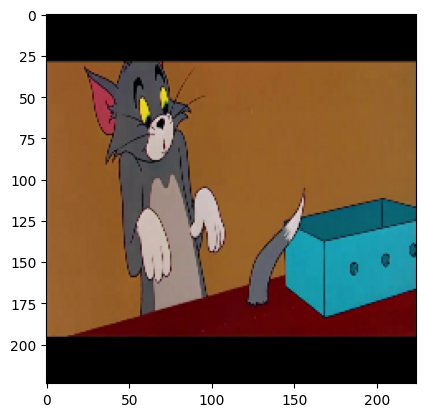

In [41]:
import matplotlib.pyplot as plt

for images, labels in iter(ds.take(1)):
    image = images[0]
    label = labels[0]
    plt.imshow(image / 255.0)
    print(label)

In [42]:
import keras
from keras import layers

class VGG(keras.Sequential):
    def __init__(self):
        super().__init__()
    
        # unit 1
        self.norm   = layers.BatchNormalization()
        self.conv11 = layers.Conv2D(64, (3, 3), activation="relu")
        self.conv12 = layers.Conv2D(64, (3, 3), activation="relu")
        self.pool1  = layers.MaxPool2D(strides=(2, 2))

        # unit 2
        self.conv21 = layers.Conv2D(128, (3, 3), activation="relu")
        self.conv22 = layers.Conv2D(128, (3, 3), activation="relu")
        self.pool2  = layers.MaxPool2D(strides=(2, 2))

        # unit 3
        self.conv31 = layers.Conv2D(256, (3, 3), activation="relu")
        self.conv32 = layers.Conv2D(256, (3, 3), activation="relu")
        self.conv33 = layers.Conv2D(256, (3, 3), activation="relu")
        self.pool3  = layers.MaxPool2D(strides=(2, 2))

        # unit 4
        self.conv41 = layers.Conv2D(512, (3, 3), activation="relu")
        self.conv42 = layers.Conv2D(512, (3, 3), activation="relu")
        self.conv43 = layers.Conv2D(512, (3, 3), activation="relu")
        self.pool4  = layers.MaxPool2D(strides=(2, 2))

        # unit 5
        self.conv51 = layers.Conv2D(512, (3, 3), activation="relu")
        self.conv52 = layers.Conv2D(512, (3, 3), activation="relu")
        self.conv53 = layers.Conv2D(512, (3, 3), activation="relu")
        self.pool5  = layers.MaxPool2D(strides=(2, 2))

        # dense
        self.dense1 = layers.Dense(4096, activation="relu")
        self.dense2 = layers.Dense(4096, activation="relu")
        self.dense3 = layers.Dense(2, activation="sigmoid")
        self.flat = layers.Flatten()

    def call(self, input_data):
        x = input_data
        x = self.norm(x)

        # unit 1
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.pool1(x)

        # unit 2
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.pool2(x)

        # unit 3
        x = self.conv31(x)
        x = self.conv32(x)
        x = self.conv33(x)
        x = self.pool3(x)

        # unit 4
        x = self.conv41(x)
        x = self.conv42(x)
        x = self.conv43(x)
        x = self.pool4(x)

        # unit 5
        x = self.conv51(x)
        x = self.conv52(x)
        x = self.conv53(x)
        x = self.pool5(x)

        # dense
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.flat(x)
        return x

In [43]:
from keras import layers
import keras
vgg = keras.Sequential([
    layers.BatchNormalization(),
    layers.Conv2D(16, (3, 3), activation="relu"),
    layers.Conv2D(16, (3, 3), activation="relu"),
    layers.MaxPool2D(strides=(2, 2)),

    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPool2D(strides=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPool2D(strides=(2, 2)),

    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPool2D(strides=(2, 2)),

    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPool2D(strides=(2, 2)),
    
    layers.BatchNormalization(),
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(2, activation="sigmoid"),
    layers.Flatten(),
])

In [44]:
input_shape = tuple(ds.element_spec[0].shape)
vgg.build(input_shape)
vgg.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_8           │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 220, 220, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 110, 110, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 108, 108, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 106, 106, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 51, 51, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 49, 49, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 47, 47, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 23, 23, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 19, 19, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1, 1, 512)      │        66,04

 Total params: 1,251,806 (4.78 MB)

 Trainable params: 1,251,160 (4.77 MB)

 Non-trainable params: 646 (2.52 KB)

In [45]:
from keras import optimizers, losses, metrics

checkpoint = keras.callbacks.ModelCheckpoint(filepath = "./checkpoints/model.keras", monitor='val_binary_accuracy', mode='max', save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", mode="max", verbose=1, patience=20)

optimizer = optimizers.SGD(learning_rate=0.03)
loss = losses.BinaryCrossentropy()
vgg.compile(optimizer=optimizer, loss=loss, metrics=[
    metrics.BinaryAccuracy(),
])

In [46]:
vgg.fit(train_ds, validation_data=cv_ds, epochs=50, callbacks=[checkpoint, early_stop])
vgg.save("./model_1.keras")

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 412ms/step - binary_accuracy: 0.6219 - loss: 0.6365 - val_binary_accuracy: 0.6289 - val_loss: 0.6867
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 404ms/step - binary_accuracy: 0.8119 - loss: 0.4135 - val_binary_accuracy: 0.3891 - val_loss: 0.7453
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - binary_accuracy: 0.8680 - loss: 0.3140 - val_binary_accuracy: 0.5344 - val_loss: 0.6653
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 404ms/step - binary_accuracy: 0.8908 - loss: 0.2768 - val_binary_accuracy: 0.3938 - val_loss: 1.1632
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 429ms/step - binary_accuracy: 0.9025 - loss: 0.2373 - val_binary_accuracy: 0.6094 - val_loss: 0.6269
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 398ms/step - binary_accuracy: 0.9326 - loss: 0.1693 - val_binary_accuracy: 0.5695 - val_loss: 0.7692
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 403ms/step - binary_accuracy: 0.9552 - loss: 0.1256 - val_binary_accuracy: 0.5164 - val_loss: 1.2301

In [11]:
import keras
model = keras.models.load_model("../ai-project/checkpoints/model.keras")

In [12]:
loss, acc = model.evaluate(test_ds)
print(f"Test loss: {loss}, Test accuracy: {acc}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - binary_accuracy: 1.0000 - loss: 0.0021
Test loss: 0.0025666584260761738, Test accuracy: 1.0


In [13]:
model.evaluate(ds)

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - binary_accuracy: 0.9991 - loss: 0.0030


[0.002817446133121848, 0.9993690848350525]